# Tri plus rapide que prévu

Dans le cas général, le coût d'un algorithme de tri est en $O(n \ln n)$. Mais il existe des cas particuliers pour lesquels on peut faire plus court. Par exemple, on suppose que l'ensemble à trier contient plein de fois le même élément.

In [1]:
%matplotlib inline

## trier un plus petit ensemble

In [2]:
import random

ens = [random.randint(0, 99) for i in range(10000)]

On peut calculer la distribution de ces éléments.

In [3]:
def histogram(ens):
    hist = {}
    for e in ens:
        hist[e] = hist.get(e, 0) + 1
    return hist


hist = histogram(ens)
list(hist.items())[:5]

[(35, 98), (89, 80), (65, 87), (8, 92), (0, 96)]

Plutôt que de trier le tableau initial, on peut trier l'histogramme qui contient moins d'élément.

In [4]:
sorted_hist = list(hist.items())
sorted_hist.sort()

Puis on recontruit le tableau initial mais trié :

In [5]:
def tableau(sorted_hist):
    res = []
    for k, v in sorted_hist:
        for i in range(v):
            res.append(k)
    return res


sorted_ens = tableau(sorted_hist)
sorted_ens[:5]

[0, 0, 0, 0, 0]

On crée une fonction qui assemble toutes les opérations. Le coût du nouveau tri est en $O(d \ln d + n)$ où $d$ est le nombre d'éléments distincts de l'ensemble initial.

In [6]:
def sort_with_hist(ens):
    hist = histogram(ens)
    sorted_hist = list(hist.items())
    sorted_hist.sort()
    return tableau(sorted_hist)


from random import shuffle

shuffle(ens)
%timeit sort_with_hist(ens)

1.26 ms ± 79.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def sort_with_nohist(ens):
    return list(sorted(ens))

In [8]:
shuffle(ens)
%timeit sort_with_nohist(ens)

1.04 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Les temps d'exécution ne sont pas très probants car la fonction `sort` est immplémentée en C et qu'elle utilise l'algorithme [timsort](https://en.wikipedia.org/wiki/Timsort). Cet algorithme est un algorithme adaptatif tel que [smoothsort](https://en.wikipedia.org/wiki/Smoothsort). Le coût varie en fonction des données à trier. Il identifie d'abord les séquences déjà triées, trie les autres parties et fusionne l'ensemble. Trier un tableau déjà trié revient à détecter qu'il est déjà trié. Le coût est alors linéaire $O(n)$. Cela explique le commentaire *The slowest run took 19.47 times longer than the fastest.* ci-dessous où le premier tri est beaucoup plus long que les suivant qui s'appliquent à un tableau déjà trié. Quoiqu'il en soit, il n'est pas facile de comparer les deux implémentations en terme de temps.

In [9]:
def sort_with_nohist_nocopy(ens):
    ens.sort()
    return ens


shuffle(ens)
%timeit sort_with_nohist_nocopy(ens)

48.3 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## évolution en fonction de n

Pour réussir à valider l'idée de départ. On regarde l'évolution des deux algorithmes en fonction du nombre d'observations.

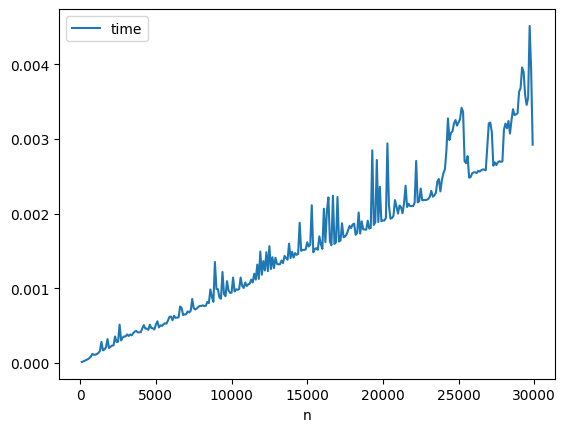

In [10]:
def tableaux_aleatoires(ns, d):
    for n in ns:
        yield [random.randint(0, d - 1) for i in range(n)]


import pandas
import time


def mesure(enss, fonc):
    res = []
    for ens in enss:
        cl = time.perf_counter()
        fonc(ens)
        diff = time.perf_counter() - cl
        res.append(dict(n=len(ens), time=diff))
    return pandas.DataFrame(res)


df = mesure(tableaux_aleatoires(range(100, 30000, 100), 100), sort_with_nohist)
df.plot(x="n", y="time");

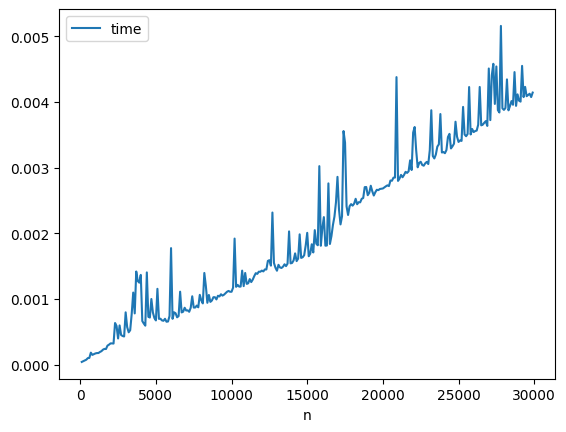

In [11]:
df = mesure(tableaux_aleatoires(range(100, 30000, 100), 100), sort_with_hist)
df.plot(x="n", y="time");

L'algorithme de tri de Python est plutôt efficace puisque son coût paraît linéaire en apparence.

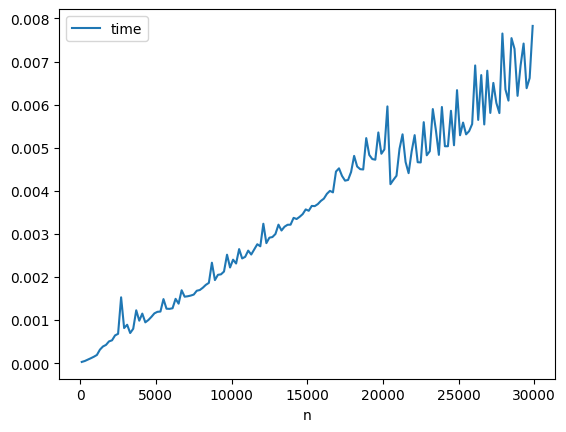

In [12]:
df = mesure(tableaux_aleatoires(range(100, 30000, 200), int(1e10)), sort_with_nohist)
df.plot(x="n", y="time");

On ajoute un logarithme.

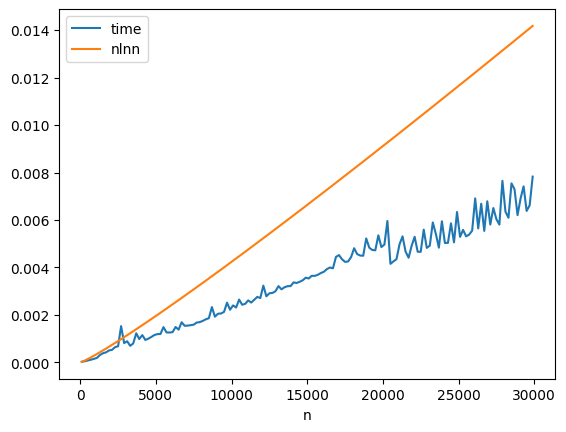

In [13]:
from math import log

df["nlnn"] = df["n"] * df["n"].apply(log) * 4.6e-8
df.plot(x="n", y=["time", "nlnn"]);

Il faut grossier le trait.

In [14]:
from math import exp

list(map(int, map(exp, range(5, 14))))

[148, 403, 1096, 2980, 8103, 22026, 59874, 162754, 442413]

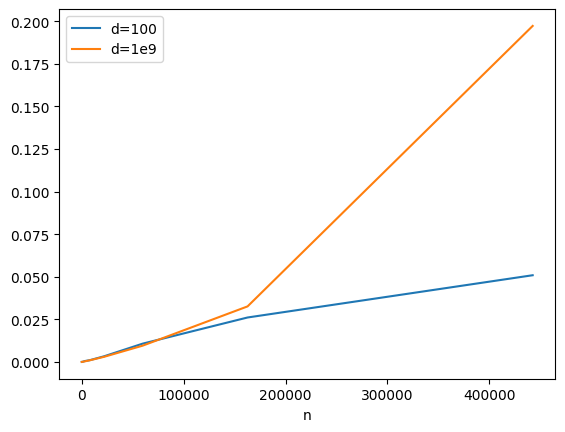

In [15]:
df100 = mesure(
    tableaux_aleatoires(map(int, map(exp, range(5, 14))), 100), sort_with_nohist
)
dfM = mesure(
    tableaux_aleatoires(map(int, map(exp, range(5, 14))), 1e9), sort_with_nohist
)
df = df100.copy()
df.columns = ["n", "d=100"]
df["d=1e9"] = dfM["time"]
df.plot(x="n", y=["d=100", "d=1e9"]);

L'algorithme de tri [timsort](https://en.wikipedia.org/wiki/Timsort) est optimisé pour le cas où le nombre de valeurs distinctes est faible par rapport à la taille du tableau à trier.